<a href="https://colab.research.google.com/github/OvinduWijethunge/Machine_Learning_Projects/blob/version-1/youtube%20spam%20classifier/ANN%20model%20with%20hp%20tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler

In [78]:
#df = pd.read_csv('model.csv')
url = 'https://raw.githubusercontent.com/OvinduWijethunge/Machine_Learning_Projects/master/youtube%20spam%20classifier/model.csv'
df = pd.read_csv(url)

In [79]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sim_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'comment_duplication', 'is_spam'],
      dtype='object')

In [80]:
dfc = df.copy()

In [81]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [84]:
from imblearn.combine import SMOTETomek
from collections import Counter

os=SMOTETomek(1)
X_train_os,y_train_os=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

X_train = X_train_os
y_train = y_train_os

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The number of classes before fit Counter({0: 6891, 1: 553})
The number of classes after fit Counter({0: 6860, 1: 6860})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [85]:
X_train=np.asarray(X_train)
y_train = np.asarray(y_train)

In [86]:
from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV

In [87]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1)) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [88]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [89]:
model

In [90]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [91]:
layers = [(20,), (40, 20), (45, 30, 15)]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
#grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',verbose=2)

from sklearn.model_selection import RandomizedSearchCV
grid= RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [92]:
 grid_result.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f45db292a90>,
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['sigmoid', 'relu'],
                                        'batch_size': [128, 256],
                                        'epochs': [30],
                                        'layers': [(20,), (40, 20),
                                                   (45, 30, 15)]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='accuracy', verbose=2)

In [93]:
grid_result.best_score_

0.9075801749271136

In [94]:
best_model = grid_result.best_estimator_

In [95]:
grid_result.best_params_

{'activation': 'relu', 'batch_size': 256, 'epochs': 30, 'layers': (45, 30, 15)}

In [96]:
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [97]:
y_pred = (y_pred>0.5)

In [98]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2761  171]
 [  55  204]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2932
           1       0.54      0.79      0.64       259

    accuracy                           0.93      3191
   macro avg       0.76      0.86      0.80      3191
weighted avg       0.95      0.93      0.93      3191



In [99]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9291758069570667

In [100]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

### ROC

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


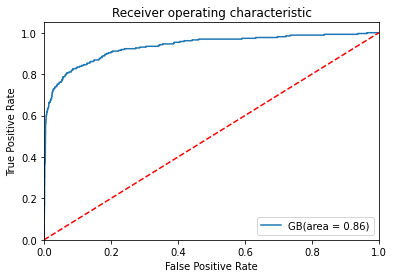

In [101]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Recall - presicion with threshold values

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


(0.0, 1.0)

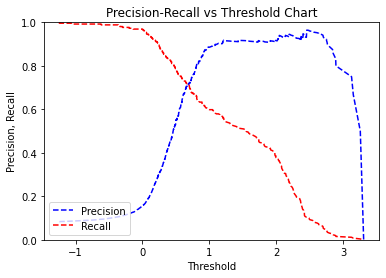

In [102]:
### Predict test_y values and probabilities based on random forest model
probs_y=best_model.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [ ]:
import pickle
#open a file, where you ant to store the data
file = open('ANN.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)

In [104]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
best_model.save('saved_model/my_model') 

AttributeError: ignored